In [1]:
import numpy as np
from datasets import load_dataset, concatenate_datasets
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
MODEL = "distilbert/distilbert-base-uncased"
SIZE = 5000

In [14]:
from datasets import concatenate_datasets

xlsum = load_dataset('anakib1/mango-truth', 'xlsum')['train'].filter(lambda x: len(x['output']) < 15000)
xlsum = concatenate_datasets([xlsum.filter(lambda x: x['label'] == 0).shuffle().take(SIZE),
                              xlsum.filter(lambda x: x['label'] == 3).map(lambda x: {"label" : 1}).shuffle().take(SIZE)])
xlsum = xlsum.train_test_split(test_size=0.3)

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

In [15]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(MODEL)

In [16]:
def preprocess(row):
    return tokenizer(row["output"], truncation=True)


data = xlsum.map(preprocess, batched=True, remove_columns=['prompt', 'user_id'])

Map:   0%|          | 0/1400 [00:00<?, ? examples/s]

Map:   0%|          | 0/600 [00:00<?, ? examples/s]

In [17]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [18]:
id2label = {0: "HUMAN", 1: "AI"}
label2id = {v: k for k, v in id2label.items()}

In [19]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

model = AutoModelForSequenceClassification.from_pretrained(MODEL, num_labels=2, id2label=id2label, label2id=label2id)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [20]:
import torch
from detectors.utils.training import calculate_classification
from dataclasses import asdict


def compute_metrics(eval_pred):
    predictions, labels = eval_pred

    predictions = torch.softmax(torch.as_tensor(predictions), dim=1)[:, 1].numpy()

    res = calculate_classification(labels, predictions)

    return asdict(res.metrics)

In [ ]:
from transformers import EarlyStoppingCallback, IntervalStrategy

training_args = TrainingArguments(
    output_dir="my_awesome_model",
    learning_rate=2e-5,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    num_train_epochs=100,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model='f1',
    save_total_limit=2,
    report_to="neptune",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=data["train"],
    eval_dataset=data["test"],
    processing_class=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

trainer.train()

In [26]:
import neptune
from transformers.integrations import NeptuneCallback

run = NeptuneCallback.get_run(trainer)

[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/mango/mango-truth/e/MNGTRTH-31


In [33]:
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_curve, roc_auc_score, \
    RocCurveDisplay

from detectors.metrics import ClassificationMetrics, SplitConclusion, ClassificationRepresentations
def tpr_at_fpr_threshold(fpr, tpr, target_fpr=0.1):
    idx = np.where(fpr >= target_fpr)[0][0]

    if fpr[idx] == target_fpr:
        return tpr[idx]
    else:
        tpr_interp = tpr[idx - 1] + (tpr[idx] - tpr[idx - 1]) * (target_fpr - fpr[idx - 1]) / (fpr[idx] - fpr[idx - 1])
        return tpr_interp

def calculate_classification(y_true, y_scores) -> ClassificationMetrics:
    y_pred = y_scores > 0.5

    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    auc = roc_auc_score(y_true, y_scores)
    return ClassificationMetrics(
        tpr_at_1_percent_fpr=tpr_at_fpr_threshold(fpr, tpr, target_fpr=0.01),
        tpr_at_10_percent_fpr=tpr_at_fpr_threshold(fpr, tpr, target_fpr=0.1),
        auc=auc,
        precision=precision_score(y_true, y_pred),
        recall=recall_score(y_true, y_pred),
        f1=f1_score(y_true, y_pred),
        accuracy=accuracy_score(y_true, y_pred)
    )


In [39]:
TEST_SIZE = 1000
test_data = load_dataset('anakib1/mango-truth', 'xlsum')['test']
test_data = concatenate_datasets([test_data.filter(lambda x: x['label'] == 0).shuffle().take(TEST_SIZE),
                              test_data.filter(lambda x: x['label'] == 3).map(lambda x: {"label" : 1}).shuffle().take(TEST_SIZE)])

def preprocess(row):
    return tokenizer(row["output"], truncation=True)


test_data = test_data.map(preprocess, batched=True, remove_columns=['prompt', 'user_id'])

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [61]:
from transformers import TrainingArguments

def perform_evaluation(data):
    
    training_args = TrainingArguments("test_trainer", report_to="none")
    
    def compute_final_metrics(eval_pred):
        predictions, labels = eval_pred
    
        predictions = torch.softmax(torch.as_tensor(predictions), dim=1)[:, 1].numpy()
        global results
        results = report_classification(labels, predictions)
        return asdict(results)
    
    
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=data,
        data_collator=data_collator,
        eval_dataset=data,
        compute_metrics=compute_final_metrics
    )
    
    trainer.evaluate()
    
    return results

In [62]:
from detectors.neptune.nexus import NeptuneNexus

nexus = NeptuneNexus()

[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/mango/mango-truth/


In [ ]:
ret = Conclusion("empty".encode("UTF-8"), "roberta", ["xlsum"], perform_evaluation(data["train"]), perform_evaluation(test_data))

C:\Users\bsvja\anaconda3\envs\cuda\Lib\site-packages\sklearn\metrics\_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
C:\Users\bsvja\anaconda3\envs\cuda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\bsvja\anaconda3\envs\cuda\Lib\site-packages\sklearn\metrics\_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


Traceback (most recent call last):
  File "C:\Users\bsvja\AppData\Local\Temp\ipykernel_15648\978323481.py", line 24, in safe_roc
    auc = roc_auc_score(y_true, y_scores)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\bsvja\anaconda3\envs\cuda\Lib\site-packages\sklearn\utils\_param_validation.py", line 213, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\bsvja\anaconda3\envs\cuda\Lib\site-packages\sklearn\metrics\_ranking.py", line 640, in roc_auc_score
    return _average_binary_score(
           ^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\bsvja\anaconda3\envs\cuda\Lib\site-packages\sklearn\metrics\_base.py", line 76, in _average_binary_score
    return binary_metric(y_true, y_score, sample_weight=sample_weight)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\bsvja\anaconda3\envs\cuda\Lib\site-packages\sklearn\metrics\_ranking.py", line 382, in _binary_roc_auc_score
    raise ValueError(
Valu

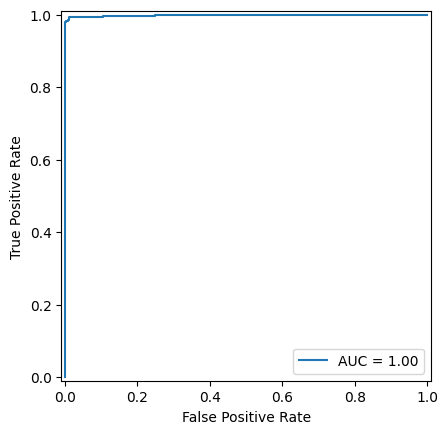

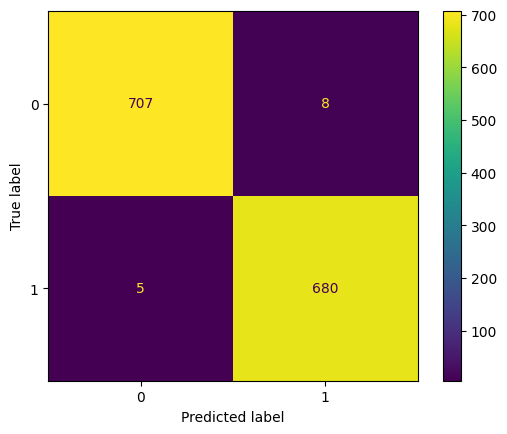

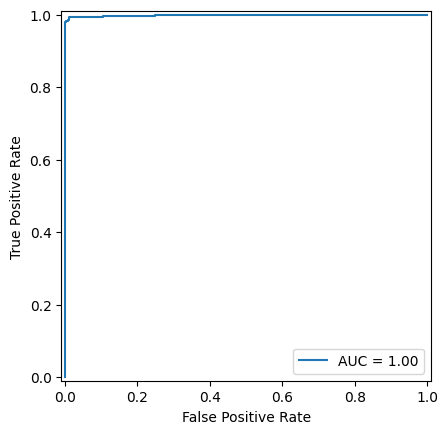

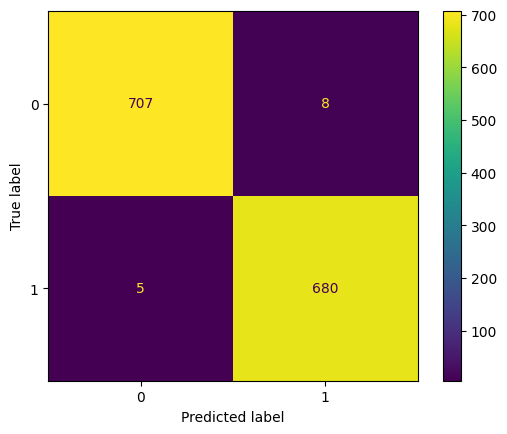

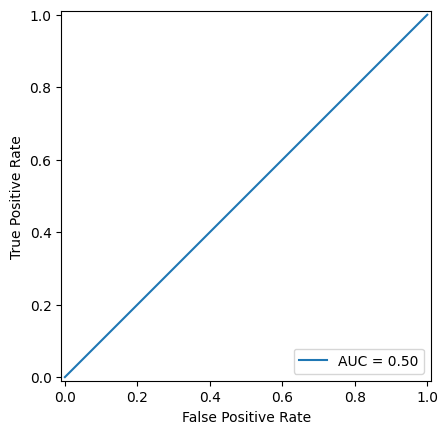

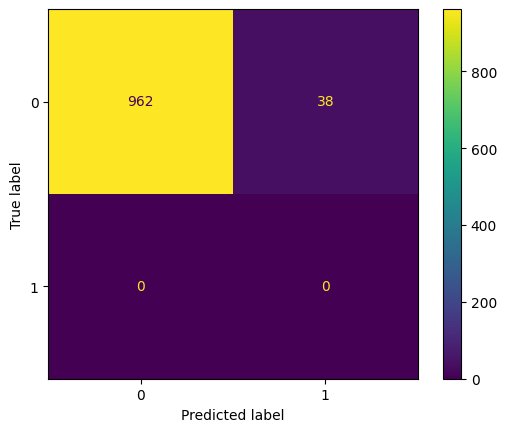

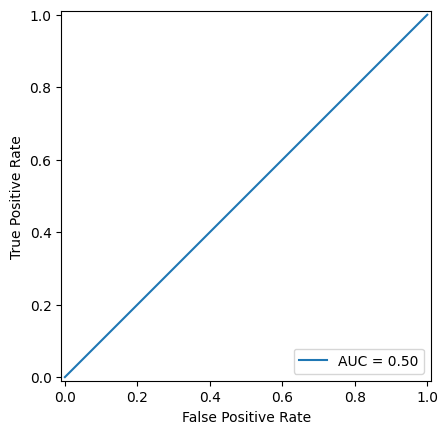

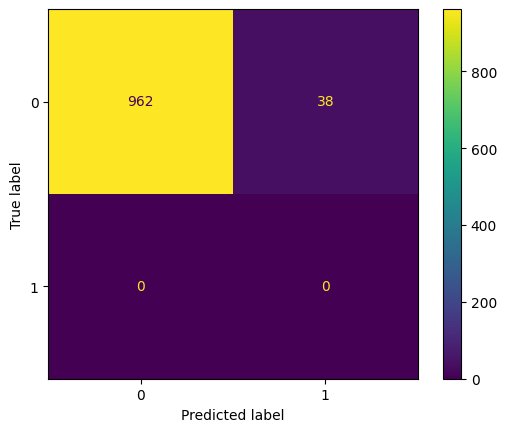

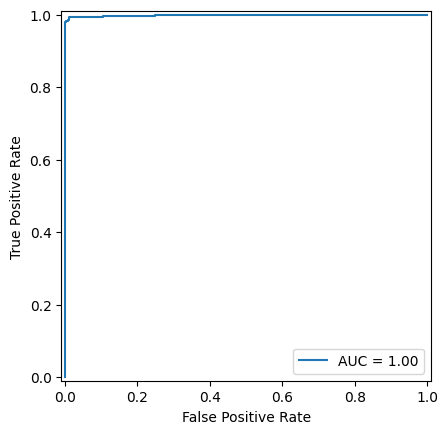

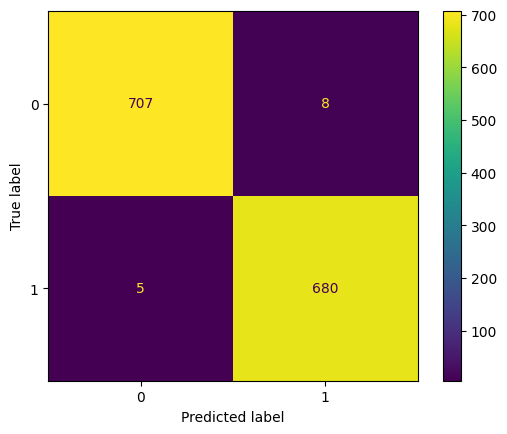

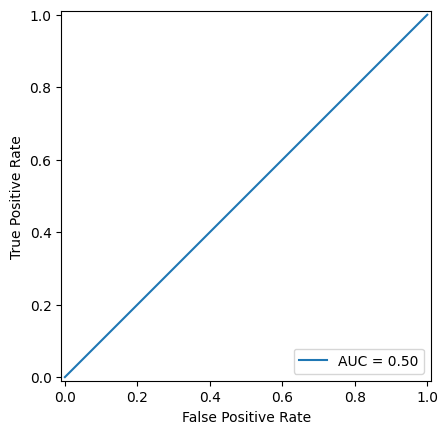

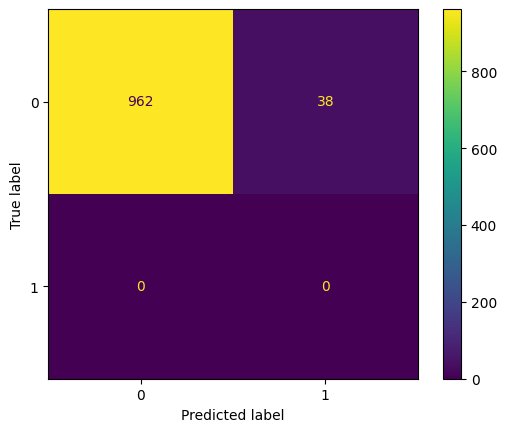

In [63]:
from uuid import uuid4
nexus.conclude_run(uuid4(), conclusion=ret, extra_data={"INFO":"DEBUG"})

In [2]:
from datasets import load_dataset
da = load_dataset('anakib1/mango-truth', 'xlsum')['test']

In [3]:
x = {} 
for y in da['label']:
    x[y] = x.get(y, 0) + 1

In [4]:
x

{0: 5394, 3: 1000}